In [1]:
from matplotlib.pyplot import rc
rc('figure', facecolor='white')

# qnlp-dataset

In this notebook, we generate and test some datasets.

**See the [qnlp-experiment](./3_qnlp-experiment.ipynb) notebook for implementation.**

In [2]:
import discopy as dp
import jax.numpy as np
from jax import jit

dp.Tensor.np = np

In [3]:
#******************************************
# Generate your corpus
#******************************************
# Sentences can be of the `word1 word2 word3 ...`.
# If you are generating the diagrams using templates then you may want to consider adding POS tags (N, V, Adj) for each word.
# Labels should be of the form [0,1] or [1,0] for binary classification.

train_sentences = [
    'Alice loves Bob.',
    'Bob loves Alice.'
]
dev_sentences = [
    'Alice loves Alice.'
]
test_sentences = [
    'Bob loves Bob.'
]

train_labels = [
    [0, 1],
    [0, 1],
]
dev_labels = [
    [1, 0],
]
test_labels = [
    [0, 1]
]

train_labels = np.array(train_labels)
dev_labels = np.array(dev_labels)
test_labels = np.array(test_labels)

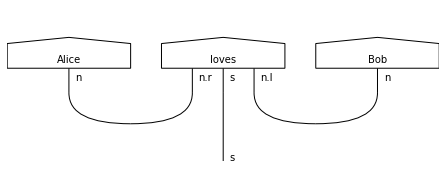

In [4]:
#******************************************
# Generate your diagrams
#******************************************
# TODO generate the DisCoCat diagrams for your corpus. There are 2 options:
# 1. Follow a few fixed templates (N V N, N V Adj N, ...)
# 2. Use the online tool to generate diagrams. 
# If you are using the online tool, consider writing a script.

s, n = dp.Ty('s'), dp.Ty('n')
Alice, loves, Bob = dp.Word('Alice', n), dp.Word('loves', n.r @ s @ n.l), dp.Word('Bob', n)

grammar = dp.Cup(n, n.r) @ dp.Id(s) @ dp.Cup(n.l, n)
parsing = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj >> grammar
           for subj in [Alice, Bob] for verb in [loves] for obj in [Alice, Bob]}

train_diagrams = [parsing[s] for s in train_sentences]
dev_diagrams = [parsing[s] for s in dev_sentences]
test_diagrams = [parsing[s] for s in test_sentences]

dp.grammar.draw(train_diagrams[0])

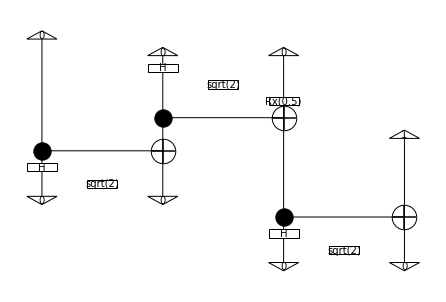

In [5]:
#******************************************
# Generate your circuits
#******************************************
# TODO: Implement your own functorial ansatz conversion!
# The `qnlp-tutorial` has some code on this.
# https://discopy.readthedocs.io/en/main/notebooks/qnlp-tutorial.html
# You may also find discopy's `IQPansatz` function useful.

def verb_ansatz(phase):
    return dp.quantum.Ket(0, 0) >> dp.quantum.H @ dp.quantum.sqrt(2) @ dp.quantum.Rx(phase) >> dp.quantum.CX

ob = {s: 0, n: 1}
ar = lambda params: {
    Alice: dp.quantum.Ket(0),
    Bob: dp.quantum.Ket(1),
    loves: verb_ansatz(params['loves'])
}

F = lambda params: dp.CircuitFunctor(ob, ar(params))

params0 = {'loves': 0.5}

train_circuits = [F(params0)(d) for d in train_diagrams]
dev_circuits = [F(params0)(d) for d in dev_diagrams]
test_circuits = [F(params0)(d) for d in test_diagrams]

train_circuits[0].draw()

In [6]:
# These imports will come in handy when you want to run
# backend simulations.

# from qiskit import IBMQ
# from pytket.extensions.qiskit import AerBackend, IBMQBackend, IBMQEmulatorBackend

In [7]:
#******************************************
# Counting parameters in your model
#******************************************

from sympy import default_sort_key
circuits = train_circuits + dev_circuits + test_circuits

# Make sure you sort your symbols as they are returned as a set.
parameters = sorted({
    s for circ in circuits for s in circ.free_symbols
}, key=default_sort_key)

In [8]:
def normalise(predicts):
    # apply smoothing to predicts
    predicts = np.abs(predicts - 1e-9)
    predicts = predicts / predicts.sum()
    return predicts

def BCE_loss(predicts, labels):
    cross_entropies = np.sum(labels * np.log2(predicts))
    cost = -1/len(labels) * np.sum(cross_entropies)
    return cost

In [9]:
def make_pred_fn(circuits):
    def pred_fn(params):
        predictions = np.array([
            normalise(np.abs(c.lambdify(*parameters)(*params).eval().array))
            for c in circuits
        ])
        return predictions
    return pred_fn

In [10]:
train_pred_fn = jit(make_pred_fn(train_circuits))
dev_pred_fn = jit(make_pred_fn(dev_circuits))
test_pred_fn = jit(make_pred_fn(test_circuits))

import numpy as onp
# onp.random.seed(0)

x0 = np.array(onp.random.random(len(parameters)))
print("Performing Just-In-Time compilation, this may take a while...")
train_pred_fn(x0)
dev_pred_fn(x0)

Performing Just-In-Time compilation, this may take a while...


DeviceArray([[1.]], dtype=float32)

In [11]:
def make_cost_fn(pred_fn, labels):
    costs = []
    accs = []
    params_list = []
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = BCE_loss(predictions, labels)
        acc = np.sum(np.round(predictions) == labels) / len(labels) / 2
        costs.append(cost)
        accs.append(acc)
        params_list.append(params)

        return cost

    return cost_fn, costs, accs, params_list

In [12]:
# Rerun this cell onwards, so you can reuse the JITed prediction functions

train_cost_fn, train_costs, train_accs, spsa_params = make_cost_fn(train_pred_fn, train_labels)
dev_cost_fn, dev_costs, dev_accs, callback_params = make_cost_fn(dev_pred_fn, dev_labels)
test_cost_fn, test_costs, test_accs, _ = make_cost_fn(test_pred_fn, test_labels)

In [13]:
from noisyopt import minimizeSPSA
minimizeSPSA(train_cost_fn, x0=x0, a=0.13, c=0.1, niter=2000, callback=dev_cost_fn)

     fun: DeviceArray(-0., dtype=float32)
 message: 'terminated after reaching max number of iterations'
    nfev: 4000
     nit: 2000
 success: True
       x: DeviceArray([], dtype=float32)

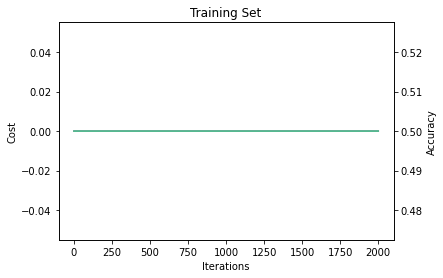

In [14]:
import matplotlib.pylab as plt
fig, ax1 = plt.subplots()
ax1.plot(train_costs[::2], color='#54436B')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Training Set')

ax2 = ax1.twinx()
ax2.plot(train_accs[::2], color='#50CB93')
ax2.set_ylabel('Accuracy')
plt.show()

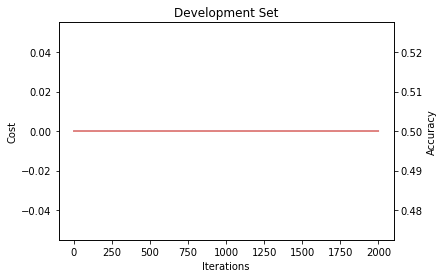

In [15]:
fig, ax1 = plt.subplots()
ax1.plot(dev_costs, color='#A03C78')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Development Set')

ax2 = ax1.twinx()
ax2.plot(dev_accs, color='#ED8E7C')
ax2.set_ylabel('Accuracy')
plt.show()

In [16]:
# when you are happy with the development set results
# run your model on the testing set

for p in callback_params:
    test_cost_fn(p)

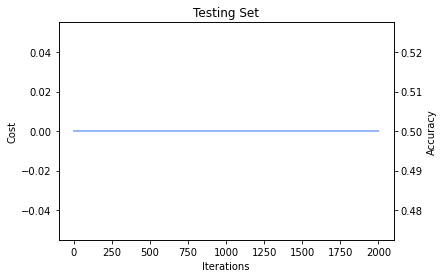

In [17]:
fig, ax1 = plt.subplots()
ax1.plot(test_costs, color='#7C83FD')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Testing Set')

ax2 = ax1.twinx()
ax2.plot(test_accs, color='#96BAFF')
ax2.set_ylabel('Accuracy')
plt.show()